### npy load

In [1]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05
session = tf1.Session(config=config)

2024-01-21 06:58:46.079047: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-21 06:58:46.174671: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-21 06:58:48.233263: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-21 06:58:52.662942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2016 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capabi

In [2]:
import matplotlib.pyplot as plt
import cv2, os, glob
import numpy as np
from PIL import Image

In [3]:
train_images =  np.load('/home/nas/data/eunju/Industrial/leather/train_images.npy')
train_labels =  np.load('/home/nas/data/eunju/Industrial/leather/train_labels.npy')

val_images =  np.load('/home/nas/data/eunju/Industrial/leather/val_images.npy')
val_labels =  np.load('/home/nas/data/eunju/Industrial/leather/val_labels.npy')

test_images =  np.load('/home/nas/data/eunju/Industrial/leather/test_images.npy')
test_labels =  np.load('/home/nas/data/eunju/Industrial/leather/test_labels.npy')

### 6:2:2 비율
- 총 92개

In [4]:
print("train_images:", train_images.shape)
print("train_labels:", train_labels.shape)
print("test_images: ", test_images.shape)
print("test_labels: ", test_labels.shape)
print("val_images:  ", val_images.shape)
print("val_labels:  ", val_labels.shape)

train_images: (55, 256, 256, 3)
train_labels: (55, 256, 256)
test_images:  (19, 256, 256, 3)
test_labels:  (19, 256, 256)
val_images:   (18, 256, 256, 3)
val_labels:   (18, 256, 256)


### 데이터 회전 추가

In [7]:
import numpy as np

# 회전 함수
def rotate_images_labels(images, labels, rotation_angle):
    rotated_images = [np.rot90(img, k=rotation_angle // 90) for img in images]
    rotated_labels = [np.rot90(lbl, k=rotation_angle // 90) for lbl in labels]

    return rotated_images, rotated_labels

# 회전할 각도 리스트
rotation_angles = [90, 180, 270]

# 데이터 회전
for angle in rotation_angles:
    rotated_train_images, rotated_train_labels = rotate_images_labels(train_images, train_labels, rotation_angle=angle)
    rotated_val_images, rotated_val_labels = rotate_images_labels(val_images, val_labels, rotation_angle=angle)
    rotated_test_images, rotated_test_labels = rotate_images_labels(test_images, test_labels, rotation_angle=angle)

    # 데이터 추가하기
    train_images = np.concatenate([train_images, rotated_train_images], axis=0)
    train_labels = np.concatenate([train_labels, rotated_train_labels], axis=0)

    val_images = np.concatenate([val_images, rotated_val_images], axis=0)
    val_labels = np.concatenate([val_labels, rotated_val_labels], axis=0)

# 데이터 차원 확인
print("Train Images Shape:", train_images.shape)
print("Train Labels Shape:", train_labels.shape)

print("Validation Images Shape:", val_images.shape)
print("Validation Labels Shape:", val_labels.shape)


Train Images Shape: (440, 256, 256, 3)
Train Labels Shape: (440, 256, 256)
Validation Images Shape: (144, 256, 256, 3)
Validation Labels Shape: (144, 256, 256)


### image 확인

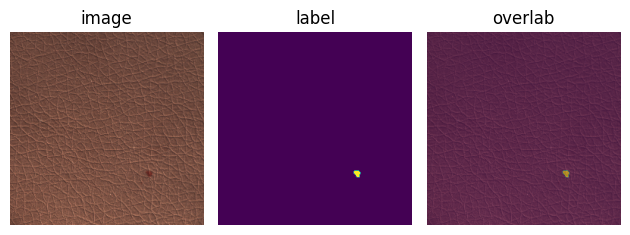

In [8]:
plt.subplot(131); plt.imshow(train_images[400]); plt.title("image") ; plt.axis(False)
plt.subplot(132); plt.imshow(train_labels[400]); plt.title("label") ; plt.axis(False)
plt.subplot(133); plt.imshow(train_images[400]); plt.axis(False)
plt.subplot(133); plt.imshow(train_labels[400], alpha=0.5) ;plt.title('overlab') ; plt.axis(False)
plt.tight_layout() ; plt.show()

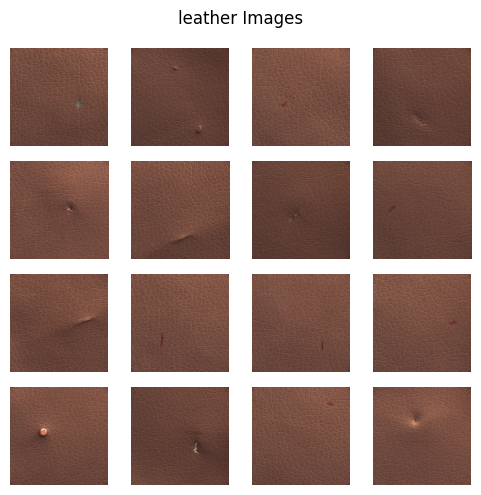

In [9]:
import random

# 랜덤 16개 선택
random_indices = random.sample(range(test_images.shape[0]), 16)
fig, axs = plt.subplots(4, 4, figsize=(5, 5))

for i, ax in enumerate(axs.flat):
    ax.imshow(test_images[random_indices[i]])
    ax.axis('off')
    
plt.suptitle("leather Images")
plt.tight_layout()
plt.show()

### 네트워크

In [10]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)

# Encoder
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(4, 4))(conv1)

conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# Middle
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool2)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

# Decoder
up8 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv2], axis=-1)
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([UpSampling2D(size=(4, 4))(conv8), conv1], axis=-1)
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(8, (3, 3), activation='relu', padding='same')(conv9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
model = Model(inputs=inputs, outputs=outputs)
model.summary()

2024-01-21 06:59:35.090398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2016 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:5e:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 8)          224       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 8)          584       ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 8)            0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, train_labels, validation_data=(val_images, val_labels), epochs=200, batch_size=16)

Epoch 1/200


2024-01-21 07:00:05.881953: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-01-21 07:00:08.612929: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-21 07:00:10.981814: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f8291be29e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-21 07:00:10.981897: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2024-01-21 07:00:10.994739: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-01-21 07:00:11.150859: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-21 07:00:11.254740: I ./tensorflow/compiler/jit/device_compil

28/28 [==============================] - 26s 216ms/step - loss: 0.2094 - accuracy: 0.9913 - val_loss: 0.2324 - val_accuracy: 0.9849
Epoch 2/200


2024-01-21 07:00:24.291062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


28/28 [==============================] - 1s 53ms/step - loss: 0.1268 - accuracy: 0.9918 - val_loss: 0.2324 - val_accuracy: 0.9849
Epoch 3/200
28/28 [==============================] - 2s 56ms/step - loss: 0.1268 - accuracy: 0.9918 - val_loss: 0.2324 - val_accuracy: 0.9849
Epoch 4/200
28/28 [==============================] - 1s 41ms/step - loss: 0.1268 - accuracy: 0.9918 - val_loss: 0.2324 - val_accuracy: 0.9849
Epoch 5/200
28/28 [==============================] - 1s 45ms/step - loss: 0.1268 - accuracy: 0.9918 - val_loss: 0.2324 - val_accuracy: 0.9849
Epoch 6/200
28/28 [==============================] - 1s 41ms/step - loss: 0.1268 - accuracy: 0.9918 - val_loss: 0.2324 - val_accuracy: 0.9849
Epoch 7/200
28/28 [==============================] - 1s 48ms/step - loss: 0.1268 - accuracy: 0.9918 - val_loss: 0.2324 - val_accuracy: 0.9849
Epoch 8/200
28/28 [==============================] - 1s 38ms/step - loss: 0.1268 - accuracy: 0.9918 - val_loss: 0.2324 - val_accuracy: 0.9849
Epoch 9/200
28/28 

28/28 [==============================] - 1s 40ms/step - loss: 0.0098 - accuracy: 0.9960 - val_loss: 0.0197 - val_accuracy: 0.9930
Epoch 60/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0097 - accuracy: 0.9960 - val_loss: 0.0205 - val_accuracy: 0.9930
Epoch 61/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0097 - accuracy: 0.9960 - val_loss: 0.0184 - val_accuracy: 0.9930
Epoch 62/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0096 - accuracy: 0.9961 - val_loss: 0.0191 - val_accuracy: 0.9928
Epoch 63/200
28/28 [==============================] - 1s 41ms/step - loss: 0.0095 - accuracy: 0.9961 - val_loss: 0.0178 - val_accuracy: 0.9928
Epoch 64/200
28/28 [==============================] - 1s 45ms/step - loss: 0.0100 - accuracy: 0.9959 - val_loss: 0.0188 - val_accuracy: 0.9927
Epoch 65/200
28/28 [==============================] - 1s 45ms/step - loss: 0.0095 - accuracy: 0.9961 - val_loss: 0.0204 - val_accuracy: 0.9931
Epoch 66/200

28/28 [==============================] - 1s 40ms/step - loss: 0.0046 - accuracy: 0.9982 - val_loss: 0.0267 - val_accuracy: 0.9931
Epoch 117/200
28/28 [==============================] - 1s 41ms/step - loss: 0.0045 - accuracy: 0.9982 - val_loss: 0.0281 - val_accuracy: 0.9931
Epoch 118/200
28/28 [==============================] - 1s 40ms/step - loss: 0.0045 - accuracy: 0.9982 - val_loss: 0.0281 - val_accuracy: 0.9930
Epoch 119/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0044 - accuracy: 0.9982 - val_loss: 0.0306 - val_accuracy: 0.9930
Epoch 120/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0051 - accuracy: 0.9979 - val_loss: 0.0248 - val_accuracy: 0.9929
Epoch 121/200
28/28 [==============================] - 1s 39ms/step - loss: 0.0057 - accuracy: 0.9977 - val_loss: 0.0262 - val_accuracy: 0.9929
Epoch 122/200
28/28 [==============================] - 1s 41ms/step - loss: 0.0048 - accuracy: 0.9981 - val_loss: 0.0295 - val_accuracy: 0.9928
Epoch 

Epoch 173/200
28/28 [==============================] - 1s 33ms/step - loss: 0.0031 - accuracy: 0.9987 - val_loss: 0.0436 - val_accuracy: 0.9925
Epoch 174/200
28/28 [==============================] - 1s 34ms/step - loss: 0.0028 - accuracy: 0.9988 - val_loss: 0.0424 - val_accuracy: 0.9926
Epoch 175/200
28/28 [==============================] - 1s 31ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 0.0452 - val_accuracy: 0.9926
Epoch 176/200
28/28 [==============================] - 1s 30ms/step - loss: 0.0023 - accuracy: 0.9991 - val_loss: 0.0434 - val_accuracy: 0.9928
Epoch 177/200
28/28 [==============================] - 1s 32ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 0.0423 - val_accuracy: 0.9927
Epoch 178/200
28/28 [==============================] - 1s 30ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 0.0468 - val_accuracy: 0.9926
Epoch 179/200
28/28 [==============================] - 1s 29ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 0.0467 - val_accuracy:

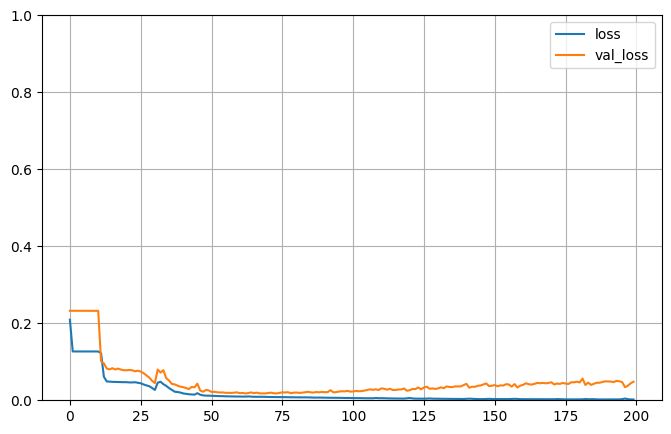

(<matplotlib.legend.Legend at 0x7f8afc646a60>, None, None)

In [12]:
plot_target = ['loss', 'val_loss']

plt.figure(figsize=(8,5))

for each in plot_target:
    plt.plot(history.history[each], label = each)
plt.ylim(0,1)
plt.legend(), plt.grid(), plt.show()

<br>

### evaluate

In [13]:
loss, acc = model.evaluate(test_images, test_labels, verbose=2)

1/1 - 1s - loss: 0.0111 - accuracy: 0.9972 - 1s/epoch - 1s/step


In [14]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

pred = model.predict(val_images)
pred = (pred > 0.5).astype(int)  # 임계값 설정

# 실제 라벨과 예측 라벨을 1차원 배열로 변환
true_labels = val_labels.flatten()
pred_labels = pred.flatten()

precision = precision_score(true_labels, pred_labels)
print("정밀도:", round(precision,3))

recall = recall_score(true_labels, pred_labels);
print("재현율:", round(recall,3))

f1 = f1_score(true_labels, pred_labels)
print("F1점수:", round(f1,3))

2024-01-21 07:05:21.206040: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


5/5 [==============================] - 1s 18ms/step


2024-01-21 07:05:21.820488: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 592.03MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-01-21 07:05:21.878166: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


정밀도: 0.829
재현율: 0.639
F1점수: 0.721


1/1 [==============================] - 1s 1s/step
diff:  167


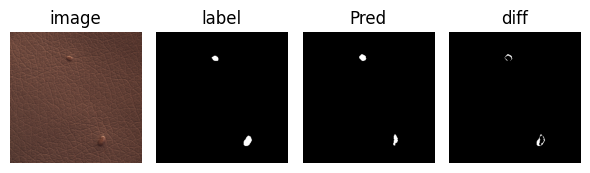

In [15]:
num = 1

test_image = test_images[num]
test_label = test_labels[num]
prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
prediction = np.where(prediction > 0.5, 1, 0)
diff= abs(test_label-prediction[:,:,0])
count = np.count_nonzero(diff==1)
print("diff: ",count)

plt.figure(figsize=(6,4))
plt.subplot(141) ;  plt.imshow(test_image, cmap='gray') ; plt.title('image');plt.axis('off')
plt.subplot(142) ;  plt.imshow(test_label, cmap='gray') ; plt.title('label'); plt.axis('off')
plt.subplot(143) ;  plt.imshow(prediction, cmap='gray') ; plt.title('Pred'); plt.axis('off')
plt.subplot(144) ; plt.imshow(diff, cmap='gray'); plt.title('diff') ; plt.axis('off')
plt.tight_layout();plt.show()

### test dataset에서 틀린 픽셀 수

In [16]:
test_images.shape

(19, 256, 256, 3)

In [17]:
diff_counts = []

for i in range(len(test_images)):
    test_image = test_images[i]
    test_label = test_labels[i]
    prediction = model.predict(np.expand_dims(test_image, axis=0))[0]
    prediction = np.where(prediction > 0.5, 1, 0)
    diff = abs(test_label-prediction[:,:,0])
    count = np.count_nonzero(diff==1)
    diff_counts.append(count)

total = sum(diff_counts)
print("total diff: ", total)

1/1 [==============================] - 0s 48ms/step
total diff:  3470


<br>

### 모델 저장

In [26]:
#model.save('.../seg.h5')